**Imports**

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix, identity
%matplotlib inline

**Checks for (x, y) are inside house OR are not inside the region of interest:**

In [0]:
boxes = [(69, 111), (69, 264),
           (138, 12), (138, 165),
           (192, 111), (192, 264),
           (261, 12), (261, 165)]

A_houses = [(138, 51), (138, 204),
              (261, 51), (261, 204)]

B_houses = [(69, 12), (69, 165),
              (192, 12), (192, 165)]


def A_corner_house(posx, posy, x, y):
  posx_ = posx - 12
  posy_ = posy + 60
  return ((posx < x) and (x < posx + 18) and (posy < y) and (y < posy + 78)) or \
   ((posx_ < x) and (x < posx_ + 13) and (posy_ < y) and (y < posy_ + 18))


def B_corner_house(posx,posy,x,y):
  posx_ = posx + 12
  return ((posx < x) and (x < posx + 18) and (posy < y) and (y < posy + 78)) or \
   ((posx_ < x) and (x < posx_ + 12) and (posy < y) and (y < posy + 18))


def is_in_square(posx, posy, x, y):
  return (posx < x) and (x < posx + 18) and (posy < y) and (y < posy+18)


def is_in_house(x, y):
  for box in boxes:
    if is_in_square(box[0], box[1], x, y):
      return True
  for house in A_houses:
    if A_corner_house(house[0], house[1], x, y):
      return True
  for house in B_houses:
    if B_corner_house(house[0], house[1], x, y):
      return True
  return False


def bounds_check(x, y):
  return x >= 300 or y >= 300 or y < 0 or x < 0

**It is assumed that we have one descrete emission from x=0 line to x=300 direction, without continious source** 

**Initialization** with parameters  from the task: grid is 300x300, tau < 1/(2size*size), k = 1/2, lambda1 =1, lambda2 = 0, number of steps = 400 000 (the more the better) 

In [28]:
size = 300
h = 1/size
k = 0.5
tau = 1/(4*k*size*size)
lambda_1 = 1
steps = 400_000
print("input n for epsilon in form of 1e-n (example: for 6 we get 1e-6):\n")
epsilon = 10**(-float(input("\n")))
dx = [1, -1, 0, 0]
dy = [0, 0, 1, -1]
sq_size = size**2
  
b = np.zeros(sq_size) 
x_v = np.zeros((sq_size, 1))

for i in range(size):
  x_v[i:size, 0] = 1
A = lil_matrix((sq_size, sq_size))

u0 = 1-4*(tau*k)/(h**2)
krest = [tau*(k/(h**2)-lambda_1/(2*h)), tau*(k/(h**2)+lambda_1/(2*h)), tau*k/(h**2), tau*k/(h**2)]

input n for epsilon in form of 1e-n (example: for 6 we get 1e-6):


6


**Calculate matrix A with respect to steam diffusion and buildings**

In [0]:
for x in range(0, size): 
  for y in range(0, size):
    _ = x * size + y
    A[_, _] = u0
    if is_in_house(x, y) or bounds_check(x, y):
        continue
    for j in range(0, 4):
      x_n = x + dx[j]
      y_n = y + dy[j]
      direction = krest[j]
      if x_n == 0:
        b[_] -= direction
      elif is_in_house(x_n, y_n) or bounds_check(x_n, y_n):
        A[_, _] += direction
      else:
        A[_, x_n * size + y_n] += direction

**Solving AX = b with iterative method**  *(X_n+1 = AX_n + b)* 

In [30]:
A = csr_matrix(A)
b = b.reshape(sq_size, -1)
# for i in range(steps - 1):
index = 0
error = 100500
while index < steps:
  x_new = A * x_v + b
  error = np.max(np.abs(x_new - x_v))
  if index % 30000 == 0: 
    print(error)
  index += 1
  if error < epsilon:
    break
  x_v = x_new

1.2491666666666665
1.2381378438508506e-05
6.537885683499667e-06
5.601427370216516e-06
4.763476020186452e-06
3.7756219211093622e-06
2.924491081190972e-06
2.2476324827991334e-06
1.722871158182926e-06
1.3194681116601714e-06
1.0102355026964105e-06


**Calculating final error**

In [31]:
print('Error = {}'.format(error))

Error = 9.999978313190994e-07


**Visualizing the result:**

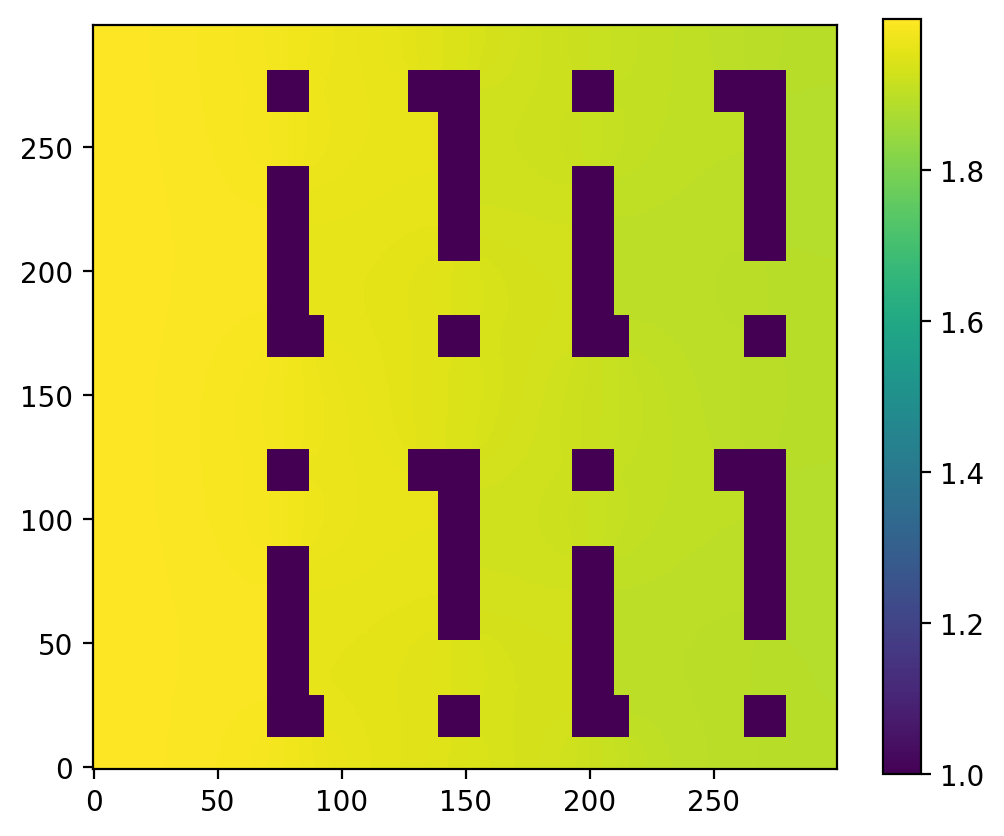

<Figure size 432x288 with 0 Axes>

In [32]:
answer = x_v.reshape(size, size)

fig = plt.figure(1, figsize=(6, 5.), dpi=200)
im = plt.imshow(1 - answer.T)
plt.gca().invert_yaxis()

plt.colorbar(im)
plt.show()
plt.savefig('eps{}.png'.format(str(epsilon)))